In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Dtype = "float64"
# Descriptive Keras model
tf.keras.backend.set_floatx(Dtype)

# Manually making sure the numpy random seeds are "the same" on all devices
np.random.seed(1234)
tf.random.set_seed(1234)


N_0=50
N_b=50
N_f=1000

lb = np.array([-5.0, 0.0]) #(x, t)
#ub = np.array([5.0, np.pi/2])
ub = np.array([5.0, 1])

# Draw uniform sample points for initial boundary data
t0 = tf.ones((N_0, 1), dtype='float64')*lb[1]
x0 = tf.random.uniform((N_0, 1), lb[0], ub[0], dtype='float64')
X_0 = tf.concat([x0, t0], axis=1)

# Boundary data
x_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype='float64')
#t_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype='float64')
tb = tf.random.uniform((N_b,1), lb[1], ub[1] , dtype='float64')
#X_b = tf.concat([x_b, t_b], axis=1)

# collect data as list
#X_data = [X_0, X_b]

#x0 = np.ones([N_b, 1]) *tf.random.uniform((N_0, 1)) #*np.random.randn(1)

def fun_u_0(x):
    return np.cos(x)*(1/(np.cosh(x)))
u0 = fun_u_0(x0)

def fun_v_0(x):
    return np.sin(x)*(1/(np.cosh( x)))
v0 = fun_v_0(x0)

#tb = np.ones([N_b, 1]) *tf.random.uniform((N_0, 1))

X_f = lb + (ub-lb)*tf.random.uniform((N_f, 2), 0, 1, dtype= 'float64')

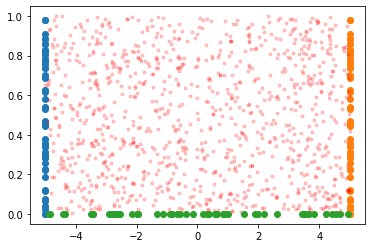

In [ ]:
import matplotlib.pyplot as plt

X_lb = np.concatenate(( 0*tb + lb[0], tb ), 1)  # (lb[0], tb)
X_ub = np.concatenate((0*tb + ub[0], tb  ), 1)  # (ub[0], tb)


x1 = X_lb[:, 0:1]
t1 = X_lb[:, 1:2]

x2 = X_ub[:, 0:1]
t2 = X_ub[:, 1:2]

plt.scatter(x1, t1)
plt.scatter(x2, t2)
plt.scatter(X_f[:,0:1], X_f[:,1:2],c='r', marker='.', alpha=0.2 )
plt.scatter(x0, t0)

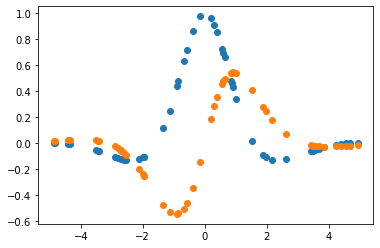

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(x0, u0)
plt.scatter(x0, v0)

In [ ]:
class NeuralNetwork():
    def __init__(self, ub, lb):
           
      self.tf_epochs = 3000
      self.lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-3,1e-4,5e-5])
      self.optim = tf.keras.optimizers.Adam(learning_rate=self.lr)
      
      self.dtype = "float64"
      tf.keras.backend.set_floatx(self.dtype)

      
      
      self.model = tf.keras.Sequential()

      self.model.add(tf.keras.Input(2))
      self.model.add(tf.keras.layers.Lambda(lambda X: 2.0*(X - lb)/(ub - lb) - 1.0))

      self.model.add(tf.keras.layers.Dense(20, activation=tf.nn.tanh, kernel_initializer="glorot_normal"))
      self.model.add(tf.keras.layers.Dense(20, activation=tf.nn.tanh, kernel_initializer="glorot_normal"))
      self.model.add(tf.keras.layers.Dense(20, activation=tf.nn.tanh, kernel_initializer="glorot_normal"))
      self.model.add(tf.keras.layers.Dense(20, activation=tf.nn.tanh, kernel_initializer="glorot_normal"))
      self.model.add(tf.keras.layers.Dense(20, activation=tf.nn.tanh, kernel_initializer="glorot_normal"))
      self.model.add(tf.keras.layers.Dense(20, activation=tf.nn.tanh, kernel_initializer="glorot_normal"))
      self.model.add(tf.keras.layers.Dense(20, activation=tf.nn.tanh, kernel_initializer="glorot_normal"))
      
      self.model.add(tf.keras.layers.Dense(2))
      

    #@tf.function(jit_compile=True)
    def grad(self, X, u):
        with tf.GradientTape() as tape:
            loss_value = self.loss(u, self.model(X))
        grads = tape.gradient(loss_value, self.model.trainable_variables)
        return loss_value, grads

    #@tf.function(jit_compile=True)
    def tf_optimization_step(self, X, u):
        loss_value, grads = self.grad(X, u)
        self.optim.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss_value

    #@tf.function(jit_compile=True)
    def tf_optimization(self, X, u):
      for epoch in range(self.tf_epochs):
          loss_value = self.tf_optimization_step(X, u)


    #@tf.function(jit_compile=True)
    def fit(self, X, u):
      # Creating the tensors
      X = tf.convert_to_tensor(X, dtype=self.dtype)
      u = tf.convert_to_tensor(u, dtype=self.dtype)
      # Optimizing
      self.tf_optimization(X, u)
      #self.nt_optimization(X, u)

    def predict(self, X):
        u_pred = self.model(X)
        return u_pred.numpy()
        
    def tensor(self, X):
        return tf.convert_to_tensor(X, dtype=self.dtype)

In [ ]:
class SchrodingerInformedNN(NeuralNetwork):
    def __init__(self, X_f, tb, ub, lb):
        super().__init__( ub, lb)

        X_lb = np.concatenate((0*tb + lb[0], tb), 1)  # (lb[0], tb)
        X_ub = np.concatenate((0*tb + ub[0], tb), 1)  # (ub[0], tb)

        self.X_lb = tf.convert_to_tensor(X_lb, dtype=self.dtype)
        self.X_ub = tf.convert_to_tensor(X_ub, dtype=self.dtype)

        # Separating the collocation coordinates
        self.x_f = tf.convert_to_tensor( X_f[:, 0:1], dtype=self.dtype)
        self.t_f = tf.convert_to_tensor( X_f[:, 1:2], dtype=self.dtype)

    # Decomposes the multi-output into the complex values and spatial derivatives
    def uvx_model(self, X):
        x = X[:, 0:1]
        t = X[:, 1:2]
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            tape.watch(t)
            Xtemp = tf.concat([x, t], axis=1)

            h = self.model(Xtemp)
            u = h[:, 0:1]
            v = h[:, 1:2]

        u_x = tape.gradient(u, x)
        v_x = tape.gradient(v, x)
        del tape

        return u, v, u_x, v_x

 
    def f_model(self):

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.x_f)
            tape.watch(self.t_f)
            # Packing together the inputs
            X_f = tf.concat([self.x_f, self.t_f], axis=1)

            # Getting the prediction
            u, v, u_x, v_x = self.uvx_model(X_f)

        # Getting the other derivatives
        u_xx = tape.gradient(u_x, self.x_f)
        v_xx = tape.gradient(v_x, self.x_f)
        u_t = tape.gradient(u, self.t_f)
        v_t = tape.gradient(v, self.t_f)

        del tape

        
        f_u = u_t + 0.5*v_xx + (u**2 + v**2)*v
        f_v = v_t - 0.5*u_xx - (u**2 + v**2)*u

        return f_u, f_v

    def loss(self, uv, uv_pred):
        #u0 = uv[:, 0:1]
        #v0 = uv[:, 1:2]

        #u0_pred = uv_pred[:, 0:1]
        #v0_pred = uv_pred[:, 1:2]

        u0 = fun_u_0(x0)
        v0= fun_v_0(x0)
        u0_pred, v0_pred, _, _ = self.uvx_model(X_0)
         
        u_lb_pred, v_lb_pred, u_x_lb_pred, v_x_lb_pred = self.uvx_model(self.X_lb)
        u_ub_pred, v_ub_pred, u_x_ub_pred, v_x_ub_pred = self.uvx_model(self.X_ub)
        f_u_pred, f_v_pred = self.f_model()

        MSE_0 = tf.reduce_mean(tf.square(u0 - u0_pred)) + tf.reduce_mean(tf.square(v0 - v0_pred))

        MSE_b = tf.reduce_mean(tf.square(u_lb_pred - u_ub_pred)) + \
            tf.reduce_mean(tf.square(v_lb_pred - v_ub_pred)) + \
            tf.reduce_mean(tf.square(u_x_lb_pred - u_x_ub_pred)) + \
            tf.reduce_mean(tf.square(v_x_lb_pred - v_x_ub_pred))

        MSE_f = tf.reduce_mean(tf.square(f_u_pred)) + tf.reduce_mean(tf.square(f_v_pred))
        loss=   MSE_0 + MSE_b + MSE_f


        tf.print(f"loss {loss}")
        return loss

    def predict(self, X_star):
        h_pred = self.model(X_star)
        u_pred = h_pred[:, 0:1]
        v_pred = h_pred[:, 1:2]
        return u_pred.numpy(), v_pred.numpy()


In [ ]:
# Creating the model

PINN = SchrodingerInformedNN( X_f, tb, ub, lb)

# Training the PINN
PINN.fit(X_0, tf.concat([u0, v0], axis=1))
# x0 or X_0
# Getting the model predictions, from the same (x,t) that the predictions were previously gotten from


loss 0.9847966927660474
loss 0.5582321251882112
loss 0.414617315385665
loss 0.405049549157974
loss 0.39291338927000713
loss 0.34701590116682657
loss 0.29425637795262694
loss 0.2642024401647771
loss 0.26712127874920255
loss 0.2910903922719463
loss 0.31361155191722456
loss 0.3187112048829496
loss 0.3051713061603686
loss 0.2824147018585698
loss 0.26171499926510033
loss 0.24958716944740925
loss 0.24571870695888784
loss 0.2452403595001404
loss 0.24315359541794473
loss 0.23764262901844468
loss 0.2304094937600666
loss 0.22467745332508188
loss 0.22270879593598408
loss 0.2244118265779503
loss 0.22767989994708598
loss 0.22997779120924164
loss 0.22993180344509215
loss 0.2278648321452739
loss 0.22514223348304074
loss 0.223014193284823
loss 0.2218156179616794
loss 0.22098343739677861
loss 0.21972407954437975
loss 0.21773074799489436
loss 0.2154046909650407
loss 0.21348787800437655
loss 0.21246790432764304
loss 0.2122375247209169
loss 0.21224325855081658
loss 0.2119570428891918
loss 0.21126545017632

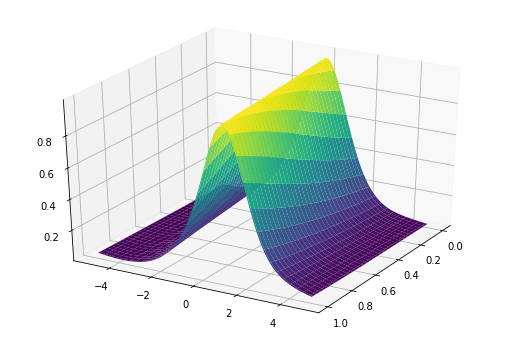

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import tensorflow as tf


N=100
x = np.linspace(lb[0], ub[0], N+1).reshape((N+1,1))
t = np.linspace(lb[1], ub[1], N+1).reshape((N+1,1))

X, T = np.meshgrid(x,t)
    
X_star = np.hstack( ( X.flatten()[:,None], T.flatten()[:, None] ) )

u_pred, v_pred = PINN.predict(X_star)
h_pred = np.sqrt(u_pred**2 + v_pred**2)

U = h_pred.reshape(N+1,N+1)

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='viridis')

ax.view_init(elev=30, azim=30)
#plt.axis('off')

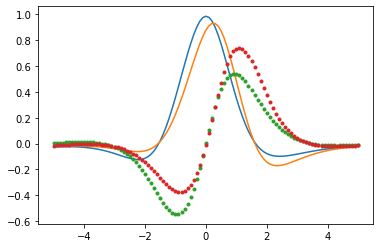

In [ ]:
u_pred=u_pred.reshape(N+1,N+1)
v_pred=v_pred.reshape(N+1,N+1)
plt.plot(x, u_pred[0,:])
plt.plot(x, u_pred[50,:])
plt.plot(x, v_pred[0,:], '.')
plt.plot(x, v_pred[50,:], '.')

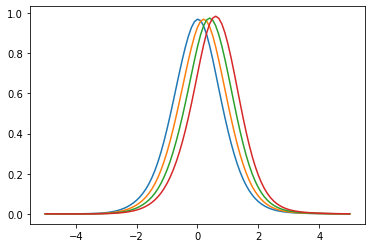

In [ ]:
#plt.subplot(2,3,3)
plt.plot(x, U[0,:]**2)
plt.plot(x, U[20,:]**2)
plt.plot(x, U[40,:]**2)
plt.plot(x, U[60,:]**2)
#plt.plot(x, U[0,:])
#plt.plot(x, U[20,:])
#plt.plot(x, U[60, :])
#plt.plot(x, U[80,:] )

# conserve quantity


increase with no of epochs

In [ ]:
dx=(ub[0] - lb[0])/(N+1)
for m in range(0,N, 10):
  print((dx/2)*( (np.abs(U[m, 0]))**2 + np.abs(U[m, N-1])**2   +2*np.sum(np.abs(U[m,1 :N-1])**2)  ))

1.930084613937061
1.9214845354080234
1.9180496477111273
1.9181332338994175
1.9201414244725254
1.9226585134936183
1.9245381018909313
1.9249614306911578
1.9234719189235918
1.9199917655706287


(10201, 2)
(10201, 1)
(101, 101)


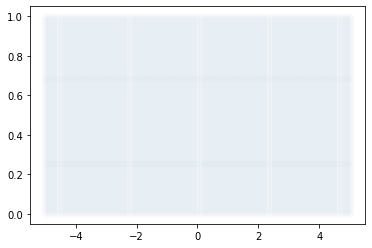

In [ ]:
print(X_star.shape)

print(h_pred.shape)

print(v_pred.shape)
plt.scatter(X_star[:, 0:1], X_star[:, 1:2], alpha=0.01 )

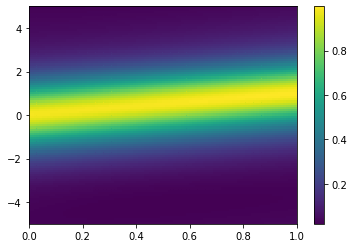

In [ ]:
plt.pcolor(T, X, U)
plt.colorbar()


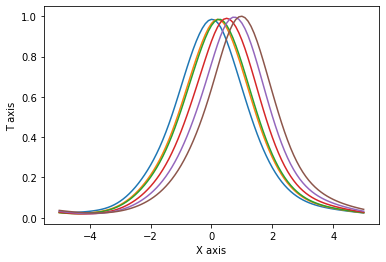

In [ ]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
H_pred = griddata(X_star, h_pred.flatten(), (X, T), method='cubic')


plt.plot(x, H_pred[0,:])
plt.plot(x, H_pred[20,:])
plt.plot(x, H_pred[25,:])
plt.plot(x, H_pred[50,:])
plt.plot(x, H_pred[75,:])
plt.plot(x, H_pred[100,:])
plt.xlabel("X axis")
plt.ylabel("T axis")
plt.show()

In [ ]:
PINN.model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 2)                 0         
                                                                 
 dense_8 (Dense)             (None, 20)                60        
                                                                 
 dense_9 (Dense)             (None, 20)                420       
                                                                 
 dense_10 (Dense)            (None, 20)                420       
                                                                 
 dense_11 (Dense)            (None, 20)                420       
                                                                 
 dense_12 (Dense)            (None, 20)                420       
                                                                 
 dense_13 (Dense)            (None, 20)               